In [ ]:
from matplotlib import pyplot
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from math import log
from gillespie.core import Mersenne
import numpy as np
from scipy.integrate import odeint

In [ ]:
class SSAModel(dict):
    """
    Container for an SSA (Stochastic Simulation Algorithm) model.
    Inherits from Python's dictionary to store species concentrations over time.
    """

    def __init__(
        self, initial_conditions, propensities, stoichiometry, max_duration=None
    ):
        """
        Initialize the SSA model with given parameters.

        Args:
            initial_conditions (dict): Dictionary of species and their initial values.
            propensities (dict): Dictionary mapping reactions to their propensity functions.
            stoichiometry (dict): Dictionary mapping reactions to their stoichiometric changes.
            max_duration (float, optional): Maximum simulation time for any trajectory.
        """

        super().__init__(
            **initial_conditions
        )  # Initialize the dictionary with species data
        self.max_duration = max_duration  # Store the maximum allowed simulation time

        # Separate valid and invalid reaction events
        self.events = []
        self.excluded_events = []

        for event, propensity in propensities.items():
            if propensity(self) == 0.0:
                # Store reactions that cannot currently occur
                self.excluded_events.append((event, stoichiometry[event], propensity))
            else:
                # Store viable reactions
                self.events.append((event, stoichiometry[event], propensity))

    def exit(self):
        """
        Determine whether the simulation should terminate.

        Returns:
            bool: True if the simulation should end, False otherwise.
        """

        # Check if the simulation time has reached the maximum duration
        if self.max_duration is not None and self["time"][-1] >= self.max_duration:
            return True

        # Check if there are no more active reactions
        return len(self.events) == 0

    def curate(self):
        """
        Update the list of valid and invalid reaction events.

        Moves reactions with zero propensity to the excluded list
        and revalidates previously excluded reactions if possible.
        """

        # Validate possible reactions
        valid_events = []
        while self.events:
            event = self.events.pop()
            if event[2](self) == 0:
                self.excluded_events.append(
                    event
                )  # Move to excluded if propensity is zero
            else:
                valid_events.append(event)
        self.events = valid_events  # Update valid event list

        # Re-evaluate previously excluded reactions
        still_excluded = []
        while self.excluded_events:
            event = self.excluded_events.pop()
            if event[2](self) > 0:
                self.events.append(event)  # Reactivate if propensity is nonzero
            else:
                still_excluded.append(event)
        self.excluded_events = still_excluded  # Update excluded event list

    def reset(self):
        """
        Reset the simulation by clearing recorded trajectories
        and restoring initial conditions.
        """

        # Reset species concentrations to their initial values
        for key in self:
            del self[key][1:]  # Remove all but the first entry in the trajectory

        # Re-evaluate which reactions are possible given the reset state
        self.curate()
        

In [ ]:
class SSA:
    """
    Container for Stochastic Simulation Algorithms (SSAs).
    Provides methods for generating reaction trajectories using
    the Direct and First-Reaction methods.
    """

    def __init__(self, model, seed=1234):
        """
        Initialize the SSA container with a model and random number generator.

        Args:
            model (SSAModel): An instance of the SSAModel class.
            seed (int, optional): Seed for the random number generator. Defaults to 1234.
        """
        self.model = model
        self.random = Mersenne(seed=seed)  # Initialize random number generator

    def direct(self):
        """
        Generate reaction trajectories using the Direct Method.

        This is an indefinite generator that simulates SSA trajectories
        until the model exits, then resets for the next trajectory.

        Yields:
            SSAModel: The updated model after each trajectory.
        """
        while True:
            while not self.model.exit():

                # Calculate reaction propensities
                weights = [
                    (rxn, sto, pro(self.model)) for (rxn, sto, pro) in self.model.events
                ]
                total_weight = sum(w[-1] for w in weights)  # Sum of propensities

                # Determine the sojourn time (time until the next reaction)
                sojourn = log(1.0 / self.random.floating()) / total_weight
                self.model["time"].append(self.model["time"][-1] + sojourn)

                # Select a reaction event
                threshold = total_weight * self.random.floating()
                while threshold >= 0.0:
                    rxn, sto, pro = weights.pop()
                    threshold -= pro

                # Apply the reaction to update species concentrations
                for species, delta in sto.items():
                    self.model[species].append(self.model[species][-1] + delta)

                self.model.curate()  # Update valid and invalid reactions

            yield self.model  # Return completed trajectory
            self.model.reset()  # Reset for the next trajectory

    def first_reaction(self):
        """
        Generate reaction trajectories using the First-Reaction Method.

        This is an indefinite generator that simulates SSA trajectories
        until the model exits, then resets for the next trajectory.

        Yields:
            SSAModel: The updated model after each trajectory.
        """
        while True:
            while not self.model.exit():

                # Compute reaction times for each event
                times = [
                    (log(1.0 / self.random.floating()) / pro(self.model), sto)
                    for (rxn, sto, pro) in self.model.events
                ]
                times.sort()  # Sort events by reaction time

                # Determine the next reaction time
                self.model["time"].append(self.model["time"][-1] + times[0][0])

                # Apply the reaction to update species concentrations
                for species, delta in times[0][1].items():
                    self.model[species].append(self.model[species][-1] + delta)

                self.model.curate()  # Update valid and invalid reactions

            yield self.model  # Return completed trajectory
            self.model.reset()  # Reset for the next trajectory

In [ ]:
# Define initial species counts and sojourn times
alpha = 2.0  # Infection rate
beta = 1.0  # Recovery rate
total = 500  # Total population
initial_s = 480  # Initial susceptible individuals
initial_i = 20  # Initial infected individuals
initial_r = 0  # Initial recovered individuals

# Define initial conditions for the model
initial_conditions = {
    "s": [initial_s],  # Susceptible count over time
    "i": [initial_i],  # Infected count over time
    "r": [initial_r],  # Recovered count over time
    "time": [0.0],  # Time progression
}

# Define propensity functions for reaction events
propensities = {
    0: lambda d: alpha * d["s"][-1] * d["i"][-1] / total,  # Infection rate
    1: lambda d: beta * d["i"][-1],  # Recovery rate
}

# Define stoichiometry changes for each reaction event
stoichiometry = {
    0: {"s": -1, "i": 1, "r": 0},  # Infection event: S -> I
    1: {"s": 0, "i": -1, "r": 1},  # Recovery event: I -> R
}

# Instantiate the epidemic SSA model container
epidemic = SSAModel(
    initial_conditions,  # Initial state
    propensities,  # Reaction propensities
    stoichiometry,  # Stoichiometric changes
)

# Instantiate the SSA container with the model
epidemic_generator = SSA(epidemic)  # SSA instance for simulation

/var/folders/5v/l6nvks1s11z6d96116s3d5z80000gn/T/ipykernel_11331/149865803.py:51: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  pyplot.tight_layout()


<Figure size 3000x3000 with 0 Axes>

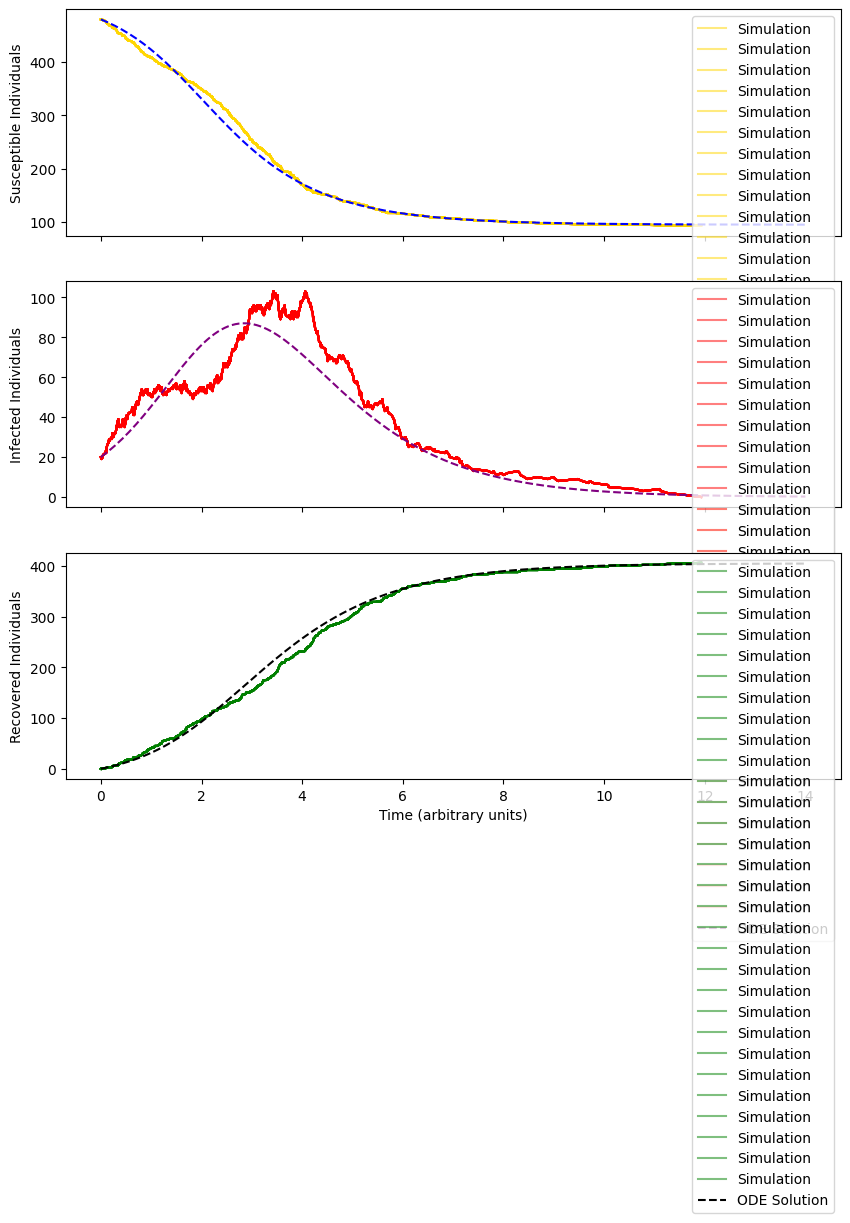

In [ ]:

# Ensure plots are shown in notebooks
pyplot.show()

# Set up figure size and resolution
pyplot.figure(figsize=(10, 10), dpi=300)

# Create subplots for susceptible, infected, and recovered individuals
fig, (axes_s, axes_i, axes_r) = pyplot.subplots(3, 1, figsize=(10, 10), sharex=True)

axes_s.set_ylabel("Susceptible Individuals")
axes_i.set_ylabel("Infected Individuals")
axes_r.set_ylabel("Recovered Individuals")
axes_r.set_xlabel("Time (arbitrary units)")

# Simulate and plot 30 trajectories
for _ in range(30):
    trajectory = next(epidemic_generator.direct())
    axes_s.plot(trajectory["time"], trajectory["s"], color="gold", alpha=0.5)
    axes_i.plot(trajectory["time"], trajectory["i"], color="red", alpha=0.5)
    axes_r.plot(trajectory["time"], trajectory["r"], color="green", alpha=0.5)
    

# Define time grid for numerical solution
t = np.linspace(0, 14, num=200)
y0 = (initial_s, initial_i, initial_r)


# Define SIR model differential equations
def differential_SIR(n_SIR, t, alpha, beta):
    S, I, R = n_SIR
    dS_dt = -alpha * S * I / total
    dI_dt = (alpha * S / total - beta) * I
    dR_dt = beta * I
    return dS_dt, dI_dt, dR_dt


# Solve the system using an ODE solver
solution = odeint(differential_SIR, y0, t, args=(alpha, beta))
S_sol, I_sol, R_sol = solution.T

# Plot numerical solution
axes_s.plot(t, S_sol, color="blue", linestyle="dashed", label="ODE Solution")
axes_i.plot(t, I_sol, color="purple", linestyle="dashed", label="ODE Solution")
axes_r.plot(t, R_sol, color="black", linestyle="dashed", label="ODE Solution")

# Add legends for clarity
axes_s.legend()
axes_i.legend()
axes_r.legend()

# Show the final plots
pyplot.tight_layout()
pyplot.show()